In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as torchdata
import numpy as np

torch.manual_seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

/opt/homebrew/Caskroom/miniforge/base/envs/base-2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 토이 데이터 생성

In [2]:
x1 = torch.arange(1,101) + torch.randn(100)
x2 = torch.cat([torch.zeros(50)+torch.abs(torch.randn(50)),torch.ones(50)-torch.abs(torch.randn(50))])
x = torch.cat([x1.unsqueeze(1),x2.unsqueeze(1)],1)
x = Variable(x)

y = torch.cat([torch.zeros(50),torch.ones(50)])
y = Variable(y).unsqueeze(1)

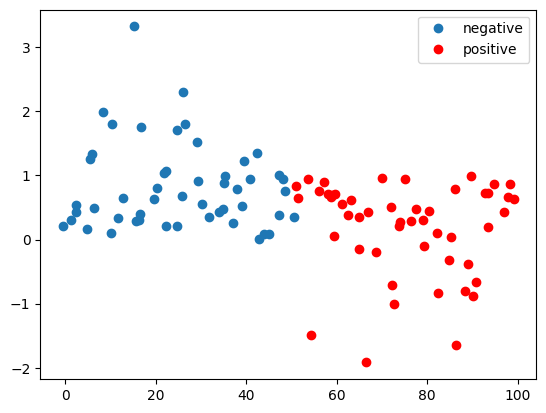

In [3]:
fig, ax = plt.subplots()
ax.plot(x[:,0].data.numpy()[:50], x[:,1].data.numpy()[:50],'o',label='negative')
ax.plot(x[:,0].data.numpy()[50:], x[:,1].data.numpy()[50:],'ro',label='positive')
ax.legend()
plt.show()

### TODO:토치 데이터와 데이터 로더 사용하기

In [4]:
data = np.loadtxt('week_2/logistic_data.csv', delimiter=',', dtype=np.float32)
data.shape

(100, 3)

In [5]:
class LogisticDataset(torchdata.Dataset):
    def __init__(self):
        data = np.loadtxt('week_2/logistic_data.csv', delimiter=',', dtype=np.float32)
        self.length = data.shape[0]
        self.x = torch.Tensor(data[:,:2])
        self.y = torch.Tensor(data[:,2])
        
    def __getitem__(self, index):
        # 인덱스에 해당하는 데이터셋 리턴
        return self.x[index], self.y[index]
    
    def __len__(self):
        # 데이터셋 수
        return self.length

In [6]:
data = LogisticDataset()
x = data.x
y = data.y.unsqueeze(1)

### 모델링

In [7]:
model = nn.Sequential(nn.Linear(2, 1),nn.Sigmoid())

for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.4707,  0.5823]], requires_grad=True)
Parameter containing:
tensor([0.6233], requires_grad=True)


### 트레이닝

In [8]:
LEARNING_RATE=0.01
EPOCH = 2000

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE)

In [9]:
for epoch in range(EPOCH):
    model.zero_grad()
    pred = model(x)
    loss = loss_function(pred, y)
    
    if epoch % 100 == 0:
        print("[%02d/%d] loss : %.3f" % (epoch, EPOCH, loss.item()))
        
    # gradient descent
    loss.backward()
    optimizer.step()

[00/2000] loss : 17.404
[100/2000] loss : 2.293
[200/2000] loss : 0.667
[300/2000] loss : 0.591
[400/2000] loss : 0.842
[500/2000] loss : 1.009
[600/2000] loss : 1.496
[700/2000] loss : 1.201
[800/2000] loss : 2.205
[900/2000] loss : 0.636
[1000/2000] loss : 1.587
[1100/2000] loss : 0.411
[1200/2000] loss : 0.289
[1300/2000] loss : 0.841
[1400/2000] loss : 0.353
[1500/2000] loss : 0.637
[1600/2000] loss : 0.647
[1700/2000] loss : 0.608
[1800/2000] loss : 0.542
[1900/2000] loss : 0.464


In [10]:
def plot_decision_region(x, y, model):
    X_p = x.data.numpy()
    y_p = y.data.numpy().reshape(100)
    markers = ('x', 's')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y_p))])

    # plot the decision surface
    x1_min, x1_max = X_p[:, 0].min() - 1, X_p[:, 0].max() + 1
    x2_min, x2_max = X_p[:, 1].min() - 1, X_p[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))

    X_pp = Variable(torch.cat([torch.Tensor(xx1).view(-1,1),torch.Tensor(xx2).view(-1,1)],1))
    Z = torch.round(model(X_pp))
    Z = Z.float().data.numpy()
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y_p)):
        plt.scatter(x=X_p[y_p == cl, 0], 
                    y=X_p[y_p == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/fw/9gdbjd851zl94gbm7f96rmcm0000gn/T/ipykernel_65335/2911557199.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X_p[y_p == cl, 0],
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


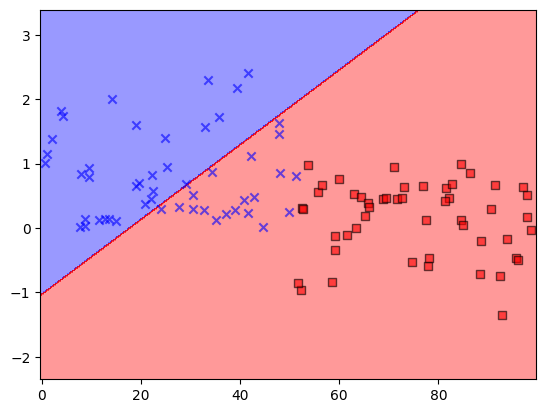

In [11]:
plot_decision_region(x, y, model)